<a href="https://colab.research.google.com/github/Farmhouse121/Financial-Data-Science-in-Python/blob/main/Miscellaneous/Index_Pairwise_Correlations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Index Pairwise Correlations
---
### Initialize the Workspace
This is done by bringing in a standard library package, which you can find here [my_library.py](https://github.com/Farmhouse121/Financial-Data-Science-in-Python/blob/main/my_library.py). This needs to be imported into the workspace of the project, and then executed. For brevity, we also turn off `UserWarning` and `FutureWarning`. You can skip that step if you want to.

In [1]:
from my_library import *

17:05:40 Starting...
17:05:40 Installing yfinance into Google notebook...
17:05:45 Installing arch into Google notebook...
17:05:51 Initialized.


In [2]:
# let's ignore some warnings that clutter the output, skip this cell if you want to see them
from warnings import filterwarnings

for warning in UserWarning,FutureWarning:
    filterwarnings("ignore",category=warning)

### Store Results in a DataFrame for Meta-Analysis

In [3]:
try:
    #raise Break # uncomment to reset meta dataframe
    meta=pd.read_pickle("/content/drive/MyDrive/meta.pickle")
    nprint("Read prior meta-analysis results from Google Drive.")

except:
    meta=pd.DataFrame({("Name","Filter"):[],"N":[],"N*":[],"rho":[]}).set_index(("Name","Filter"))
    nprint("Created empty DataFrame for meta-analysis results.")

17:05:51 Read prior meta-analysis results from Google Drive.


### Load List of Index Members
---
This has been set up to allow you to select one of the known indices by setting that value for `indexname`. In the future, more indices might be added via similar code branches.

In [89]:
nprint("Getting members of %s index." % (indexname:='S&P SmallCap 600')) # choose from'Dow','S&P 500','NASDAQ-100','S&P MidCap 400','S&P SmallCap 600','S&P 900','S&P 1500'

def loadindex(indexname):
    """Load the specified index and return the members and the first date for data extraction."""

    if indexname=='S&P 500':
        display(index:=pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0].rename(columns={"Symbol":"Ticker"}).set_index("Ticker"))
        first_date=index['Date added'].max() # add data is in table returned

    elif indexname=='NASDAQ-100':
        display(index:=pd.read_html('https://en.wikipedia.org/wiki/Nasdaq-100')[4].set_index("Ticker"))
        first_date=datetime.now().strftime("%Y-01-02") # NASDAQ rebalances (normally) on the first day of the year. Jan'1st. is *always* a holiday

    elif indexname=='S&P MidCap 400':
        display(index:=pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_400_companies')[0].rename(columns={"Symbol":"Ticker"}).set_index("Ticker"))
        updates=pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_400_companies')[1].set_index(("Date","Date"))
        updates.index=list(map(lambda x:pd.Period(x.split('[')[0],'D'),updates.index))
        first_date=str(updates.index.max())

    elif indexname=='S&P SmallCap 600':
        display(index:=pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_600_companies')[0].rename(columns={"Symbol":"Ticker"}).set_index("Ticker"))
        updates=pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_600_companies')[1].set_index(("Date","Date"))
        updates.index=list(map(lambda x:pd.Period(x.split('[')[0],'D'),updates.index))
        first_date=str(updates.index.max())

    elif indexname=='S&P 900': # union of S&P 500 and S&P MidCap 400
        sp500,dt500=loadindex('S&P 500')
        sp400,dt400=loadindex('S&P MidCap 400')
        columns=list(set(sp500.columns).intersection(set(sp400.columns)))
        index=pd.concat([sp500[columns],sp400[columns]]).sort_index()
        first_date=max([dt500,dt400])

    elif indexname=='S&P 1500': # union of S&P 500, S&P MidCap 400, and S&P SmallCap 600
        sp900,dt900=loadindex('S&P 900')
        sp600,dt600=loadindex('S&P SmallCap 600')
        columns=list(set(sp900.columns).intersection(set(sp600.columns)))
        index=pd.concat([sp900[columns],sp600[columns]]).sort_index()
        first_date=max([dt900,dt600])

    elif indexname=='Dow': # Dow Jones
        display(index:=pd.read_html('https://en.wikipedia.org/wiki/Dow_Jones_Industrial_Average')[1].rename(columns={"Symbol":"Ticker"}).set_index("Ticker"))
        first_date=index['Date added'].max()

    else:
        raise ValueError("Don't know how to load members of %s Index!" % indexname)

    return index[~index.index.duplicated()],first_date # drop duplicates in case some exist

index,first_date=loadindex(indexname)
nprint("Total of %d stocks. First date for data extract is %s." % (index.shape[0],first_date))

19:31:38 Getting members of S&P SmallCap 600 index.


,Company,GICS Sector,GICS Sub-Industry,Headquarters Location,SEC filings,CIK
Ticker,,,,,,
AAP,"Advance Auto Parts, Inc.",Consumer Discretionary,Automotive Retail,"Raleigh, North Carolina",view,1158449
AAT,American Assets Trust,Real Estate,Diversified REITs,"San Diego, California",view,1500217
ABCB,Ameris Bancorp,Financials,Regional Banks,"Atlanta, Georgia",view,351569
ABG,Asbury Automotive Group,Consumer Discretionary,Automotive Retail,"Duluth, Georgia",view,1144980
ABM,"ABM Industries, Inc.",Industrials,Environmental & Facilities Services,"New York City, New York",view,771497
...,...,...,...,...,...,...
XNCR,Xencor Inc,Health Care,Biotechnology,"Pasadena, California",view,1326732
XPEL,"XPEL, Inc.",Consumer Discretionary,Auto Parts & Equipment,"San Antonio, Texas",view,1767258
XRX,Xerox,Information Technology,"Technology Hardware, Storage & Peripherals","Norwalk, Connecticut",view,1770450


19:31:39 Total of 602 stocks. First date for data extract is 2024-08-09.


### Measure Correlations for a Random Sample of Index Member Pairs
---
This analysis is survivorship bias free because data is taken strictly from the last index rebalance only.

In [90]:
results=pd.DataFrame({"Trial":list(range(N:=5000)),"Ticker 1":[""]*N,"Ticker 2":[""]*N,"Correlation":[np.nan]*N,"Sample":[np.nan]*N}).set_index("Trial")

nprint("Getting daily data for all index stocks, starting on {:s}.".format(first_date))
data=download(list(map(lambda x:x.replace(".","-"),index.index)),first_date) # Yahoo! Finance uses - for subclasses of equity

for i in tqdm(results.index):
    df=data["Adj Close"].sample(2,axis=1)
    df.columns=pd.MultiIndex.from_product([["Adj Close"],df.columns])

    if df.shape[0]<10:
        continue

    for ticker in (tickers:=list(set(df.columns.get_level_values(1)))):
        df[('Return',ticker)]=df[('Adj Close',ticker)].pct_change()*hundred

    df.dropna(inplace=True)
    df.index=pd.DatetimeIndex(df.index).to_period('D')
    results.loc[i,"Ticker 1"]=tickers[0]
    results.loc[i,"Ticker 2"]=tickers[1]
    results.loc[i,"Correlation"]=df["Return"].corr().iloc[0,1]*hundred
    results.loc[i,"Sample"]=df.shape[0]

results.set_index(["Ticker 1","Ticker 2"],inplace=True)
results.loc["Mean","Sample"]=results.shape[0]
results.loc["Mean","Correlation"]=(m:=results["Correlation"].mean())
display(results)

19:31:39 Getting daily data for all index stocks, starting on 2024-08-09.


[**********************91%*******************    ]  547 of 602 completedERROR:yfinance:Could not get exchangeTimezoneName for ticker 'SITC' reason: 'chart'
[*********************100%***********************]  602 of 602 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['SITC']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')


  0%|          | 0/5000 [00:00<?, ?it/s]

<ipython-input-90-f14c7a9c5a0e>:24: PerformanceWarning: indexing past lexsort depth may impact performance.
  results.loc["Mean","Sample"]=results.shape[0]
<ipython-input-90-f14c7a9c5a0e>:25: PerformanceWarning: indexing past lexsort depth may impact performance.
  results.loc["Mean","Correlation"]=(m:=results["Correlation"].mean())


,,Correlation,Sample
Ticker 1,Ticker 2,,
HBI,EAT,31.137432,27.0
MMI,WGO,65.379588,27.0
BHE,MXL,59.362434,27.0
SCSC,NPK,52.505772,27.0
PLAB,URBN,35.475556,27.0
...,...,...,...
TFIN,KW,42.124197,27.0
NWBI,B,46.624568,27.0
VRRM,WSR,28.711354,27.0


### Make a Histogram

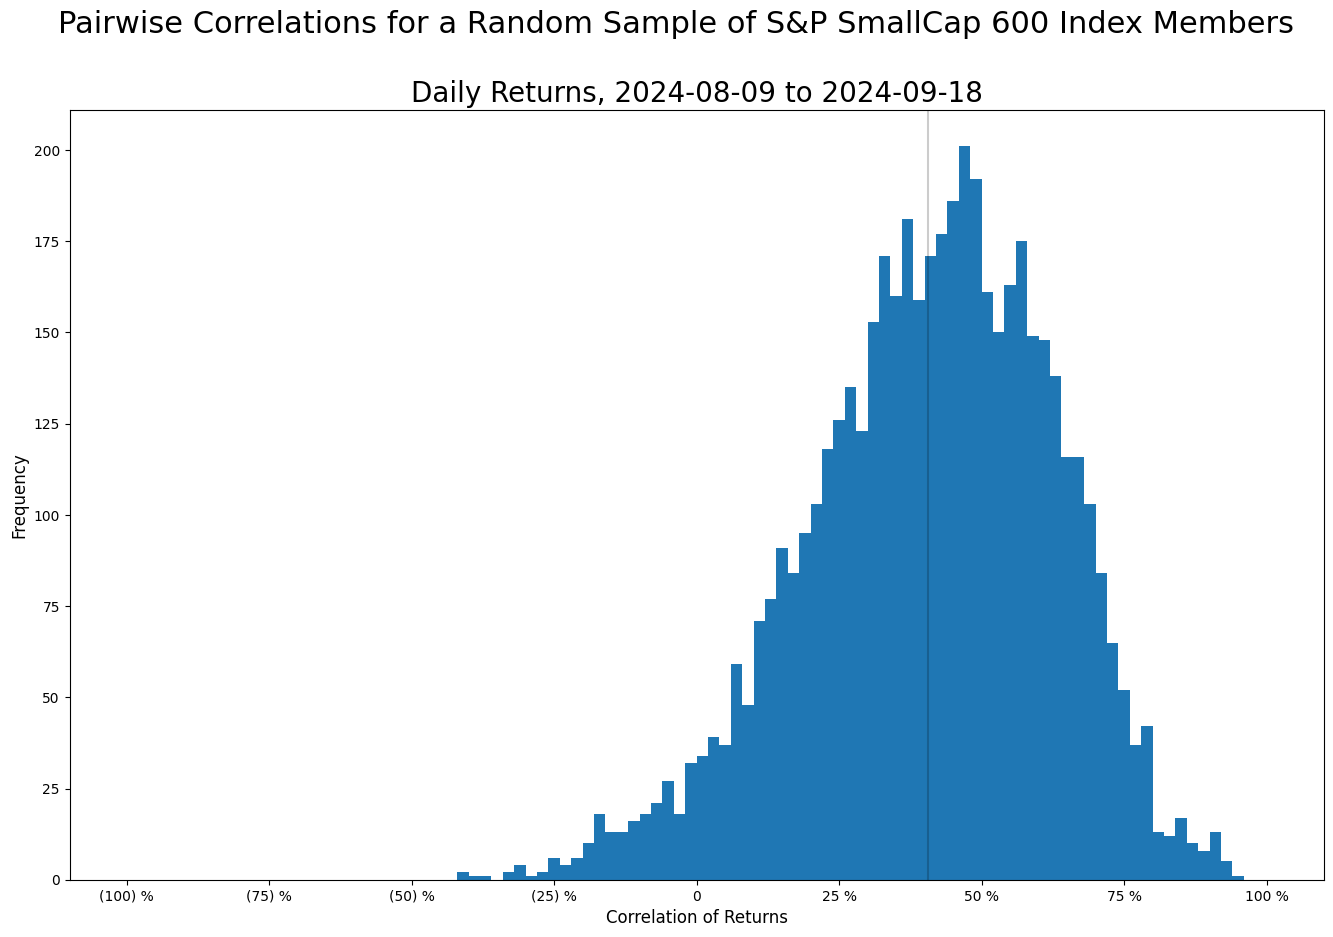

In [91]:
figure,plot=pl.subplots(figsize=(ten*GoldenRatio,ten))
bins,counts,patches=plot.hist(results.loc[results.index!="Mean",'Correlation'].to_numpy(),bins=np.linspace(-hundred,hundred,101))
figure.suptitle(title:="Pairwise Correlations for a Random Sample of %s Index Members" % indexname,fontsize=22)
plot.set_title(subtitle:="Daily Returns, %s to %s" % (first_date,today("%Y-%m-%d")),fontsize=20)
plot.set_xlabel("Correlation of Returns",fontsize=12)
plot.xaxis.set_major_formatter(PercentLabels(0))
plot.set_ylabel("Frequency",fontsize=12)
plot.yaxis.set_major_formatter(CountLabels())
plot.axvline(m,color='black',alpha=0.2)
figure.savefig(title+".png",dpi=300,bbox_inches='tight')

### Execute the $N^*$ vs. $N$ Analysis
---
$N^*$ is the effective degrees of freedom found within a portfolio of size $N$. This is computed by comparing the variance of the portfolio returns to the variance we would expect if all the stocks were independent.

In [101]:
results=pd.DataFrame({"Sample":range(1,(n:=1000)+1),"Assets":[np.nan]*n,"Portfolio":[np.nan]*n}).set_index("Sample") # n is number of trials
nprint("Getting daily data for all index stocks, starting on %s." % first_date)
closes=data['Adj Close']
closes.index=pd.DatetimeIndex(closes.index).to_period('B')

nprint("Beginning analysis for {:,d} trials. This may take about {:.1f} minutes...".format(n,n/2.38/60)) # approx empirical timings

if (filter:="Down") is not None: # choose "Up", "Down" or None
    nprint("Limiting analysis to portfolio %s days only." % filter.lower())
    returns=closes.pct_change().iloc[1:]*hundred
    select=returns.mean(axis=1)>zero if filter=='Up' else returns.mean(axis=1)<zero if filter=='Down' else ~returns.mean(axis=1).isna()

for i in tqdm(results.index): # for each trial, pick a random sample of stocks with portfolio sizes uniformly distributed between 1 and maximum, one of 2^503-1 choices
    returns=pd.DataFrame()

    for ticker in closes[np.random.choice(closes.columns,np.random.randint(1,closes.shape[1]+1),replace=False)]:
        returns[ticker]=closes[ticker].pct_change().dropna()*hundred # compute all adjusted returns, ticker by ticker

        if returns[ticker].shape[0]<1: # exclude time-series that are all NA's
            returns.drop(columns=ticker,inplace=True)

        else:
            returns=returns.copy() # 'cos it frags, apparently

    returns['Portfolio']=returns.mean(axis=1) # equal weighted portfolio return
    results.loc[i,"Assets"]=returns.shape[1]-1 # number of assets we ended up with
    results.loc[i,"Independent"]=returns.loc[select,[a for a in returns if a!="Portfolio"]].var().sum()/results.loc[i,"Assets"]**2 # if no correlation, portfolio variance is total variance divided by square of number of assets
    results.loc[i,"Portfolio"]=returns.loc[select,'Portfolio'].var() # variance of portfolio returns for same period as individual returns

results.dropna(inplace=True)
results["Effective D.o.F."]=results["Independent"]/results["Portfolio"]*results["Assets"]
display(results)
nprint("Done.")

19:49:09 Getting daily data for all index stocks, starting on 2024-08-09.
19:49:09 Beginning analysis for 1,000 trials. This may take about 7.0 minutes...
19:49:09 Limiting analysis to portfolio down days only.


  0%|          | 0/1000 [00:00<?, ?it/s]

,Assets,Portfolio,Independent,Effective D.o.F.
Sample,,,,
1,511.0,0.521825,0.010849,10.623591
2,313.0,0.564572,0.015666,8.685311
3,533.0,0.514864,0.008868,9.179959
4,217.0,0.509179,0.021370,9.107421
5,101.0,0.490980,0.044663,9.187574
...,...,...,...,...
996,223.0,0.489675,0.024101,10.975865
997,361.0,0.563328,0.015235,9.762935
998,523.0,0.531491,0.010215,10.051937


19:57:54 Done.


### Make a Plot

19:57:54 Down Days: Effective D.o.F. Limit 10.28, Implied Correlation 9.58 %.


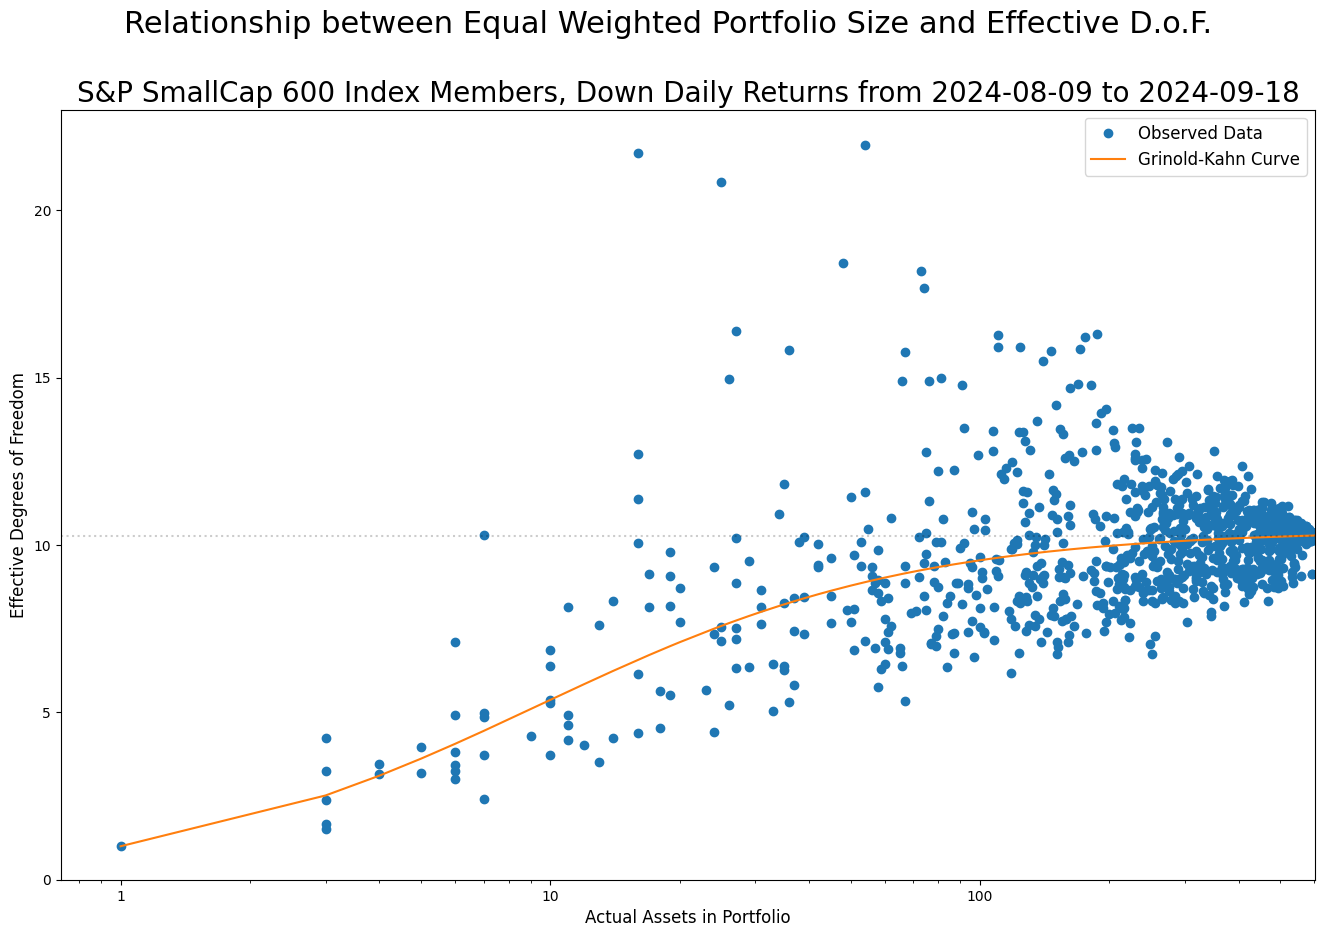

In [102]:
Nstar,Nact=tuple(results.sort_values("Assets").iloc[-1][["Effective D.o.F.","Assets"]])
rho=(Nact-Nstar)/((Nact-one)*Nstar)
nprint("{:s} Days: Effective D.o.F. Limit {:,.2f}, Implied Correlation {:.2f} %.".format(filter if filter is not None else "All",Nstar,rho*hundred))
meta=pd.concat([meta,pd.DataFrame({
    "Name":[(indexname,filter if filter is not None else "")],
     "N":[Nact],
    "N*":[Nstar],
    "rho":[rho]
}).set_index("Name")])

figure,plot=pl.subplots(figsize=(ten*GoldenRatio,ten))
plot.plot(x:=results["Assets"].to_numpy(),y:=results["Effective D.o.F."].to_numpy(),'o',label='Observed Data')
plot.plot(xp:=np.append([] if max(x)>100 else [zero],np.unique(np.sort(x))),xp/(one+(xp-one)*rho),'-',label='Grinold-Kahn Curve')
plot.set_xscale('log' if max(x)>100 else 'linear')
plot.set_ylim(zero,None)
plot.set_xlabel("Actual Assets in Portfolio",fontsize=12)
plot.set_ylabel("Effective Degrees of Freedom",fontsize=12)
figure.suptitle(title:="Relationship between Equal Weighted Portfolio Size and Effective D.o.F.",fontsize=22)
plot.set_title("%s Index Members, %s Daily Returns from %s to %s" % (indexname,filter if filter is not None else "All",first_date,pd.Timestamp.today().strftime("%Y-%m-%d")),fontsize=20)
plot.set_xlim(zero,index.shape[0])
plot.legend(fontsize=12)
plot.axhline(Nstar,color='black',linestyle=':',alpha=0.2)
plot.xaxis.set_major_formatter(CountLabels())
figure.savefig(title+".png",dpi=300,bbox_inches='tight')

### Meta-Analysis
---

In [103]:
meta.index=pd.MultiIndex.from_tuples(meta.index)
meta.index.names=("Name","Filter")
meta=meta.loc[~meta.index.duplicated(keep='last')]
display(meta.sort_values("N",ascending=True))

try:
    meta.to_pickle("/content/drive/MyDrive/meta.pickle")
    nprint("Saved meta-analysis results to Google Drive.")

except:
    raise RuntimeError("You need to mount your Google Drive to save results.")

N         N*       rho
Name             Filter                             
Dow                        30.0   5.179205  0.165255
                 Down      30.0   9.700549  0.072159
                 Up        30.0  10.027255  0.068684
NASDAQ-100       Up       101.0  12.755672  0.069180
                          101.0   5.634579  0.169250
                 Down     101.0  10.703658  0.084360
S&P MidCap 400            401.0   3.372589  0.294749
                 Up       401.0   7.906424  0.124296
                 Down     401.0   5.637069  0.175341
S&P 500                   502.0   4.901689  0.202423
                 Up       503.0  11.658441  0.083954
                 Down     503.0   9.573288  0.102673
S&P SmallCap 600          602.0   3.497499  0.284730
                 Up       602.0   5.397453  0.183917
                 Down     602.0  10.281668  0.095758
S&P 900                   904.0   3.964192  0.251430
S&P 1500                 1506.0   4.115399  0.242487

19:57:55 Saved meta-analysis results to Google Drive.


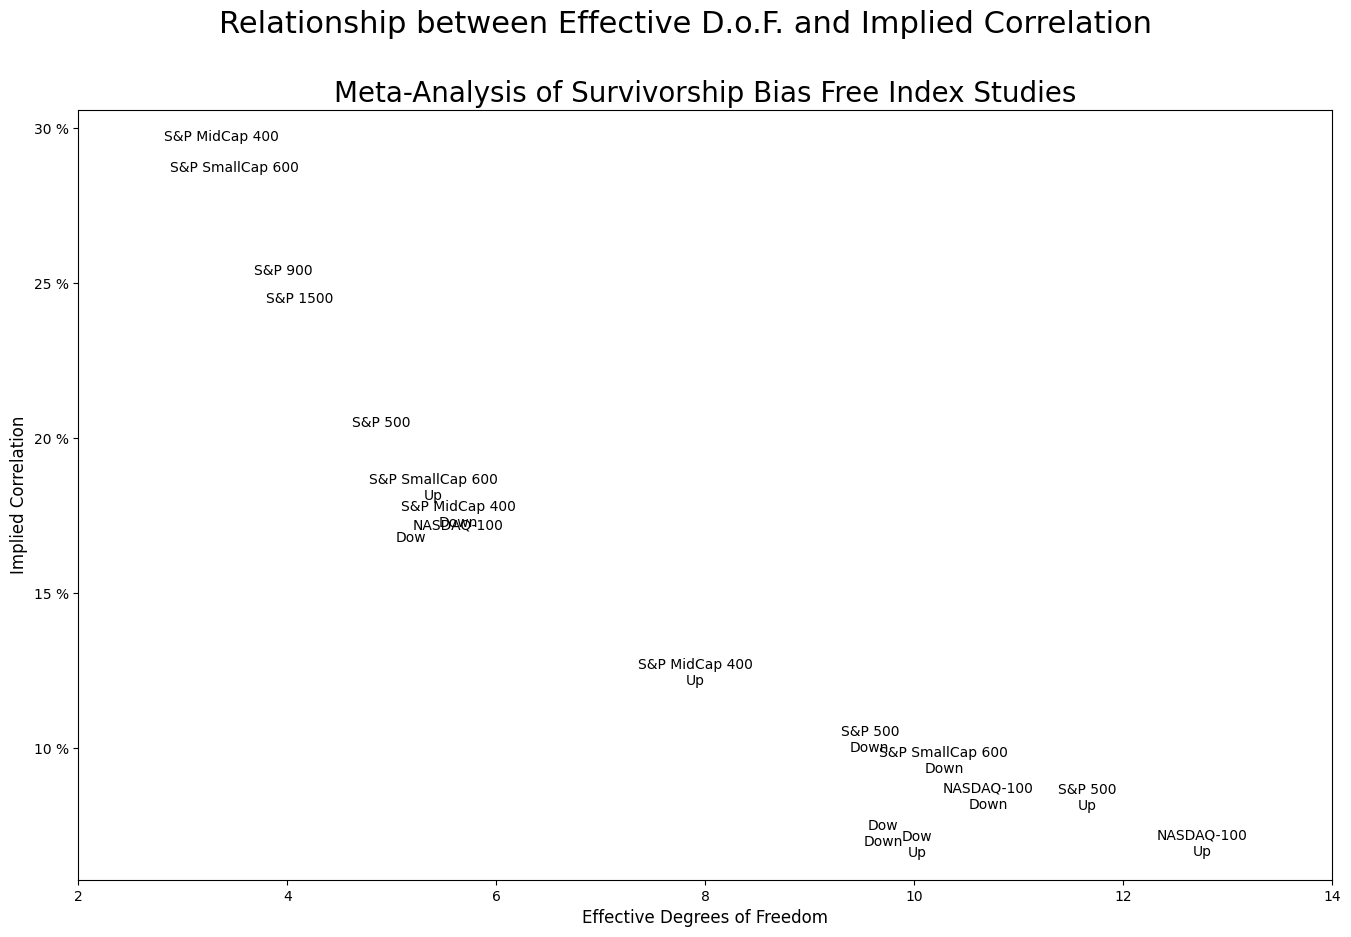

In [104]:
figure,plot=pl.subplots(figsize=(ten*GoldenRatio,ten))
plot.plot(x:=meta["N*"].to_numpy(),y:=meta["rho"].to_numpy()*hundred,'o',label='Observed Data',alpha=zero)
plot.set_xlabel("Effective Degrees of Freedom",fontsize=12)
plot.set_ylabel("Implied Correlation",fontsize=12)
plot.yaxis.set_major_formatter(PercentLabels(0))
figure.suptitle(title:="Relationship between Effective D.o.F. and Implied Correlation",fontsize=22)
plot.set_title("Meta-Analysis of Survivorship Bias Free Index Studies",fontsize=20)
plot.set_xlim(np.floor(meta["N*"]).min()-one,np.ceil(meta["N*"]).max()+one)

for i in meta.index:
    plot.text(x:=meta.loc[i,"N*"],y:=meta.loc[i,"rho"]*hundred,s:="\n".join(i),ha='center',va='center',fontsize=10)

figure.savefig(title+".png",dpi=300,bbox_inches='tight')

### $\LaTeX$ Code for the Formulae in the Articles
---

$$
V_P=\mathbb{V}\!\left[\frac{1}{N}\sum_{i=1}^Nr_{it}\right]=\frac{1}{N^2}\mathbb{V}\!\left[\sum_{i=1}^Nr_{it}\right]
$$

$$
V_P=\frac{1}{N^2}\sum_{i=1}^N\sigma_i^2+\frac{2}{N^2}\sum_{i=1}^N\sum_{j=i+1}^N\sigma_i\sigma_j\rho_{ij}=V_I+V_C
$$

$$
V_I=\frac{1}{N}\left(\frac{1}{N}\sum_{i=1}^N\sigma_i^2\right)=\frac{\overline{\sigma^2}}{N}
$$

$$
\mathbb{V}[\bar{x}]=\frac{\sigma^2}{N}\;\mathrm{where}\;\mathbb{V}[x_i]=\mathbb{V}[x_j]=\sigma^2\;\mathrm{and}\;\mathbb{C}[x_i,x_j]=0\;\forall\;i,j
$$

$$
V_P=V_I\left(1+\frac{V_C}{V_I}\right)=\frac{\overline{\sigma^2}}{N}\left(1+\frac{V_C}{V_I}\right)
$$

$$
V_P=\frac{\overline{\sigma^2}}{N^*}\;\mathrm{where}\;N^*=N\frac{V_I}{V_P}
$$

$$
\sum_{N=1}^M\begin{pmatrix}M\\ N\end{pmatrix}=2^M-1
$$

$$
2^{503}-1\approx3.3\times10^{150}
$$

$$
\mathbb{V}[r_{it},r_{jt}]=\sigma_{it}\sigma_{jt}\rho\;\Leftrightarrow\;V_t=S_tRS_t\;\mathrm{where}\;R=\begin{pmatrix}
1&\rho&\cdots&\rho\\
\rho&1&\cdots&\rho\\
\vdots&&\ddots&\vdots\\
\rho&\rho&\cdots&1
\end{pmatrix}\;\mathrm{and}\;
S_t=\begin{pmatrix}
\sigma_{1t}&0&\cdots&0\\
0&\sigma_{2t}&\cdots&0\\
\vdots&&\ddots&\vdots\\
0&0&\cdots&\sigma_{Nt}
\end{pmatrix}
$$